In [3]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

figsize = (18, 5)
plt.rcParams["figure.figsize"] = figsize

In [4]:
def process_prediction(pred):
    return np.array(list(map(float, pred.split(","))))


def unprocess_prediction(pred):
    pred = [p for p in pred]
    return ",".join(map(str, pred))


def one_hot_to_tags_list(pred):
    if not isinstance(pred, (list, np.ndarray)):
        pred = list(map(float, pred.split(",")))
    tags = []
    for i, p in enumerate(pred):
        if p > 0.5:
            tags.append(i)
    if not tags:
        tags.append(np.argmax(pred))
    return tags

In [5]:
# public: 0.3066045963604239

data_dir = Path("../_EXPERIMENTS")
prediction_dfs = [
    # # # TOP # # #
    ( 1.1, pd.read_csv(data_dir / "12folds__transformer_crop120_cutmix_1/prediction_infer_fixed.csv")),  # 0.2996 crop=120 fixed_crop
#     ( 1.0, pd.read_csv(data_dir / "12folds__transformer_crop120_cutmix_1/prediction_fold12.csv")),  # 0.2995 crop=120
    ( 1.0, pd.read_csv(data_dir / "12folds__transformer_4heads_maxcrop240_cutmix_1/prediction.csv")),   # 0.298862293773901 crop=240
    ( 1.0, pd.read_csv(data_dir / "12folds__transformer_fixed_crop_2/prediction_fold12.csv")),   # 0.29520697045826705 crop=50
    # # # # # # # #
    
    (0.3, pd.read_csv(data_dir / "20folds__transformer_4heads_1/prediction_4.csv")),  # 0.2993926553692722 crop 120 4heads 4layers    
    (0.2, pd.read_csv(data_dir / "10folds__transformer__attn_pooling__flip_cut_aug__lion__resample_1/prediction.csv")),   # 0.29489815827421006
    (0.2, pd.read_csv(data_dir / "12folds__transformer_rms__attn_pooling__flip_cut_aug__lion__resample_1/prediction_fold12.csv")),  # 0.29461715481539386
    (0.1, pd.read_csv(data_dir / "10folds__transformer__attn_pooling__flip_cut_aug__lion__weighted_bce_2/prediction.csv")),   # 0.28324435351541744

    (0.1, pd.read_csv(data_dir / "12folds__mlp_2/fold0_prediction_4max.csv")),   # 0.24
]
weights = [p[0] for p in prediction_dfs]
ps = [p[1] for p in prediction_dfs]
merged_p = ps[0].copy()

for p in ps:
    p.prediction = p.prediction.apply(process_prediction)

for track in tqdm(ps[0].track.values):
    tps = [
        p[p.track == track].prediction.iloc[0]
        for p in ps
    ]
    preds = np.average(tps, axis=0, weights=weights).tolist()

    merged_p.loc[merged_p.track == track, "prediction"] = (
        unprocess_prediction(preds)
    )

  0%|          | 0/25580 [00:00<?, ?it/s]

In [6]:
merged_p.to_csv("ensemble_prediction.csv", index=False)

231

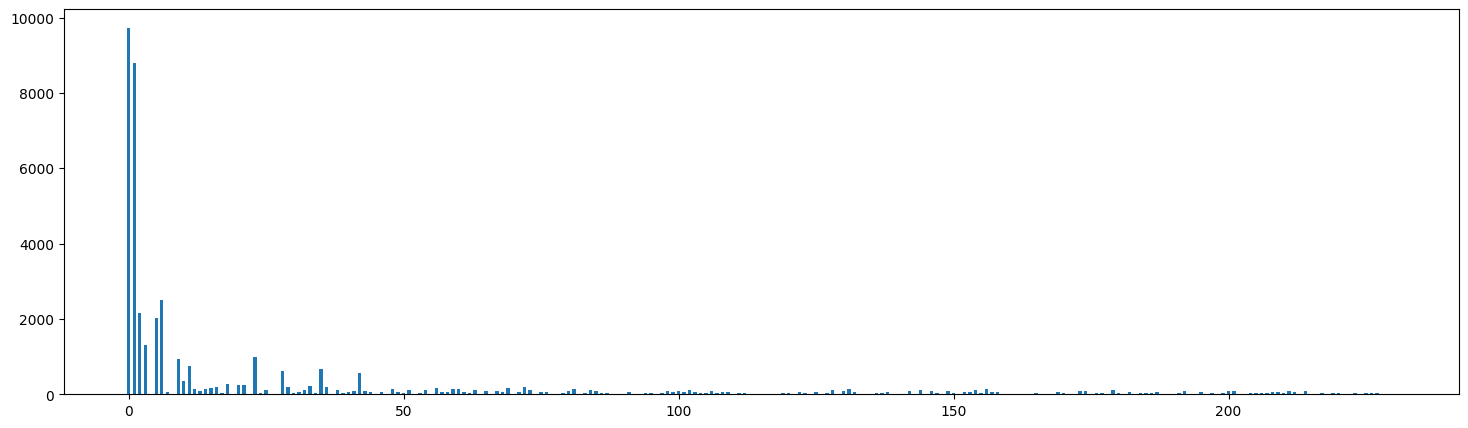

In [7]:
# for p in ps + [merged_p]:
for p in [merged_p]:
    tags = p.prediction.apply(one_hot_to_tags_list)
    pred_tags_cnt = tags.explode().value_counts()
    display(len(pred_tags_cnt))
    plt.bar(range(len(pred_tags_cnt)), pred_tags_cnt.sort_index().values, width=0.6)
    plt.show()